# Instacart Recommendation System: Feature Engineering and Modeling

## Notebook by Lauren Dellon

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from library.sb_utils import save_file

## Read files

In [2]:
aisles = pd.read_csv('/Users/laurendellon/Documents/Springboard/Capstone_3_Docs/aisles.csv')
departments = pd.read_csv('/Users/laurendellon/Documents/Springboard/Capstone_3_Docs/departments.csv')
products = pd.read_csv('/Users/laurendellon/Documents/Springboard/Capstone_3_Docs/products.csv')
orders = pd.read_csv('/Users/laurendellon/Documents/Springboard/Capstone_3_Docs/orders.csv')
order_products_prior = pd.read_csv('/Users/laurendellon/Documents/Springboard/Capstone_3_Docs/order_products__prior.csv')
order_products_train = pd.read_csv('/Users/laurendellon/Documents/Springboard/Capstone_3_Docs/order_products__train.csv')

## Merge order_products_prior with orders

In [3]:
order_products_complete = pd.merge(order_products_prior, orders, on='order_id')
order_products_complete.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


## Merge products with aisles and departments

In [4]:
products_merged = pd.merge(products, aisles, on='aisle_id', how='left')
products_merged = pd.merge(products_merged, departments, on='department_id', how='left')
products_merged.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


## Merge order_products_prior with products_merged

In [5]:
order_products_merged = pd.merge(order_products_prior, products_merged, on='product_id')
order_products_merged.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,Organic Egg Whites,86,16,eggs,dairy eggs


## CREATING FEATURES FOR USERS

### Reordered ratio of each user

In [6]:
user_reorder_ratio = pd.DataFrame(order_products_complete.groupby('user_id')['reordered'].aggregate('mean')).reset_index()
user_reorder_ratio = user_reorder_ratio.rename(columns={'reordered':'user_reorder_ratio'})

### Total number of orders of each user

In [7]:
user_total_orders = pd.DataFrame(order_products_complete.groupby('user_id')['order_number'].aggregate('max')).reset_index()
user_total_orders = user_total_orders.rename(columns={'order_number':'user_total_orders'})

### Total items purchased by each user

In [8]:
user_total_items = pd.DataFrame(order_products_complete.groupby('user_id')['add_to_cart_order'].aggregate('count')).reset_index()
user_total_items = user_total_items.rename(columns={'add_to_cart_order':'user_total_items'})

### Average days since prior order for each user

In [9]:
user_avg_days = pd.DataFrame(order_products_complete.groupby(['user_id'])['days_since_prior_order'].aggregate('mean')).reset_index()
user_avg_days = user_avg_days.rename(columns={'days_since_prior_order':'user_avg_days'})

### Average basket size of each user


In [10]:
basket_size = pd.DataFrame(order_products_complete.groupby(['user_id','order_number'])['add_to_cart_order'].aggregate('max')).reset_index()
user_avg_basket_size = pd.DataFrame(basket_size.groupby(['user_id'])['add_to_cart_order'].aggregate('mean')).reset_index()
user_avg_basket_size = user_avg_basket_size.rename(columns={'add_to_cart_order':'user_avg_basket_size'})

### Merge all features for users

In [11]:
user_features = user_reorder_ratio.merge(user_total_orders, on='user_id', how='left')
user_features = user_features.merge(user_total_items, on='user_id', how='left')
user_features = user_features.merge(user_avg_days, on='user_id', how='left')
user_features = user_features.merge(user_avg_basket_size, on='user_id', how='left')
user_features.head()

,user_id,user_reorder_ratio,user_total_orders,user_total_items,user_avg_days,user_avg_basket_size
0,1,0.694915,10,59,20.259259,5.900000
1,2,0.476923,14,195,15.967033,13.928571
2,3,0.625000,12,88,11.487179,7.333333
3,4,0.055556,5,18,15.357143,3.600000
4,5,0.378378,4,37,14.500000,9.250000


## CREATING FEATURE FOR PRODUCTS

### Reordered ratio of each product

In [12]:
prod_reorder_ratio = pd.DataFrame(order_products_complete.groupby('product_id')['reordered'].agg('mean')).reset_index()
prod_reorder_ratio = prod_reorder_ratio.rename(columns={'reordered':'prod_reorder_ratio'})

### Number of purchases of each product

In [13]:
prod_num_purchases = pd.DataFrame(order_products_complete.groupby('product_id')['order_id'].agg('count')).reset_index()
prod_num_purchases = prod_num_purchases.rename(columns={'order_id':'prod_num_purchases'})

### Merge all features for products

In [14]:
prod_features = prod_reorder_ratio.merge(prod_num_purchases, on='product_id', how='left')
prod_features.head()

,product_id,prod_reorder_ratio,prod_num_purchases
0,1,0.613391,1852
1,2,0.133333,90
2,3,0.732852,277
3,4,0.446809,329
4,5,0.600000,15


## Create dataframe of users and products

In [15]:
user_products = order_products_complete[['user_id','product_id']]
user_products = user_products.sort_values(by=['user_id','product_id'])
user_products = user_products.drop_duplicates()
user_products = user_products.reset_index(drop=True)
user_products.head()

,user_id,product_id
0,1,196
1,1,10258
2,1,10326
3,1,12427
4,1,13032


## Merge user_products with user features and product features

In [16]:
features_df = user_products.merge(user_features, on='user_id', how='left')
features_df = features_df.merge(prod_features, on='product_id', how='left')
features_df.head()

,user_id,product_id,user_reorder_ratio,user_total_orders,user_total_items,user_avg_days,user_avg_basket_size,prod_reorder_ratio,prod_num_purchases
0,1,196,0.694915,10,59,20.259259,5.9,0.776480,35791
1,1,10258,0.694915,10,59,20.259259,5.9,0.713772,1946
2,1,10326,0.694915,10,59,20.259259,5.9,0.652009,5526
3,1,12427,0.694915,10,59,20.259259,5.9,0.740735,6476
4,1,13032,0.694915,10,59,20.259259,5.9,0.657158,3751


## Merge features_df with original product attributes

In [17]:
features_df = features_df.merge(products_merged, on='product_id', how='left')
# Drop irrelevant columns
features_df = features_df.drop(columns=['product_name','aisle','department'])
features_df.head()

,user_id,product_id,user_reorder_ratio,user_total_orders,user_total_items,user_avg_days,user_avg_basket_size,prod_reorder_ratio,prod_num_purchases,aisle_id,department_id
0,1,196,0.694915,10,59,20.259259,5.9,0.776480,35791,77,7
1,1,10258,0.694915,10,59,20.259259,5.9,0.713772,1946,117,19
2,1,10326,0.694915,10,59,20.259259,5.9,0.652009,5526,24,4
3,1,12427,0.694915,10,59,20.259259,5.9,0.740735,6476,23,19
4,1,13032,0.694915,10,59,20.259259,5.9,0.657158,3751,121,14


## Locate training orders

In [18]:
orders_train_test = orders.loc[orders.eval_set == 'train']
orders_train_test = features_df.merge(orders_train_test, on='user_id', how='left')
orders_train_test = orders_train_test.merge(order_products_train, on=['product_id','order_id'], how='left')
# Drop unnecessary columns
orders_train_test = orders_train_test.drop(['order_id','eval_set','add_to_cart_order'],axis=1)
# Fill NaN's with 0
orders_train_test = orders_train_test.fillna(0)
orders_train_test.head()

,user_id,product_id,user_reorder_ratio,user_total_orders,user_total_items,user_avg_days,user_avg_basket_size,prod_reorder_ratio,prod_num_purchases,aisle_id,department_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196,0.694915,10,59,20.259259,5.9,0.776480,35791,77,7,11.0,4.0,8.0,14.0,1.0
1,1,10258,0.694915,10,59,20.259259,5.9,0.713772,1946,117,19,11.0,4.0,8.0,14.0,1.0
2,1,10326,0.694915,10,59,20.259259,5.9,0.652009,5526,24,4,11.0,4.0,8.0,14.0,0.0
3,1,12427,0.694915,10,59,20.259259,5.9,0.740735,6476,23,19,11.0,4.0,8.0,14.0,0.0
4,1,13032,0.694915,10,59,20.259259,5.9,0.657158,3751,121,14,11.0,4.0,8.0,14.0,1.0


## Mean encoding categorical variables (aisle_id and department_id)

In [19]:
cols = ['aisle_id','department_id']
for col in cols:
    mean = orders_train_test.groupby(col).reordered.mean()
    orders_train_test[col] = orders_train_test[col].map(mean)
orders_train_test.head()

,user_id,product_id,user_reorder_ratio,user_total_orders,user_total_items,user_avg_days,user_avg_basket_size,prod_reorder_ratio,prod_num_purchases,aisle_id,department_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196,0.694915,10,59,20.259259,5.9,0.776480,35791,0.081894,0.080516,11.0,4.0,8.0,14.0,1.0
1,1,10258,0.694915,10,59,20.259259,5.9,0.713772,1946,0.044555,0.056200,11.0,4.0,8.0,14.0,1.0
2,1,10326,0.694915,10,59,20.259259,5.9,0.652009,5526,0.107899,0.081928,11.0,4.0,8.0,14.0,0.0
3,1,12427,0.694915,10,59,20.259259,5.9,0.740735,6476,0.061736,0.056200,11.0,4.0,8.0,14.0,0.0
4,1,13032,0.694915,10,59,20.259259,5.9,0.657158,3751,0.058826,0.054128,11.0,4.0,8.0,14.0,1.0


## Split orders into training set and testing set

In [20]:
X = orders_train_test.drop(columns='reordered')
y = orders_train_test.reordered

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [22]:
y_train.value_counts(), y_test.value_counts()

(0.0    8735270
 1.0     580297
 Name: reordered, dtype: int64,
 0.0    3743859
 1.0     248527
 Name: reordered, dtype: int64)

In [23]:
from sklearn.utils import resample

# Combine them back for resampling
train_data = pd.concat([X_train,y_train],axis=1)

# Separate minority and majority classes
negative = train_data[train_data.reordered==0]
positive = train_data[train_data.reordered==1]

# Downsample majority
neg_downsampled = resample(negative, replace=True, n_samples=len(positive), random_state=27)

# Combine minority and downsampled majority
downsampled = pd.concat([positive,neg_downsampled])

# Check new class counts
downsampled.reordered.value_counts()

1.0    580297
0.0    580297
Name: reordered, dtype: int64

In [24]:
# Re-split the data
X = downsampled.drop(columns='reordered')
y = downsampled.reordered
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

In [25]:
y_train.value_counts(), y_test.value_counts()

(1.0    406208
 0.0    406207
 Name: reordered, dtype: int64,
 0.0    174090
 1.0    174089
 Name: reordered, dtype: int64)

In [26]:
X_train = X_train.set_index(['user_id','product_id'])
X_test = X_test.set_index(['user_id','product_id'])

## Checking histograms

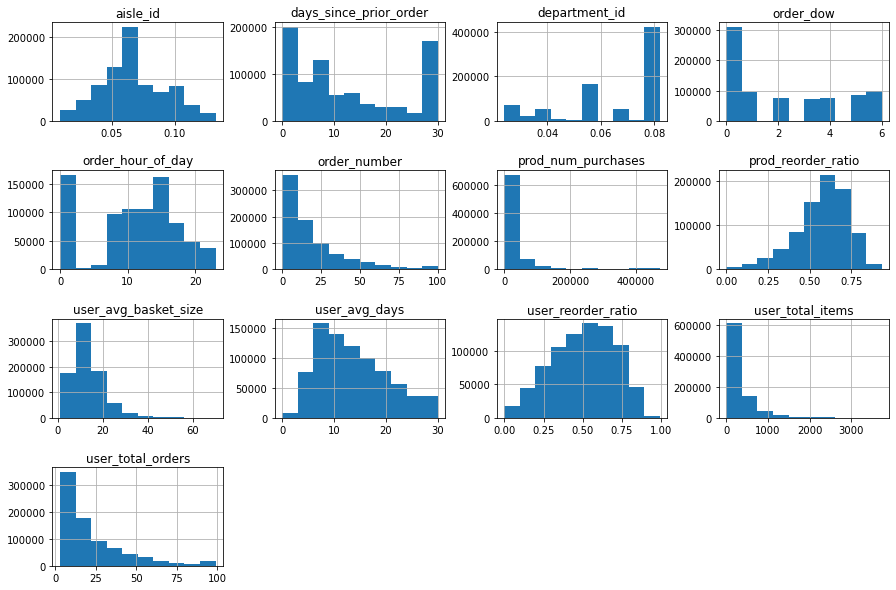

In [27]:
X_train.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

## Scaling

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test),columns=X_test.columns)

In [29]:
X_train.head()

,user_reorder_ratio,user_total_orders,user_total_items,user_avg_days,user_avg_basket_size,prod_reorder_ratio,prod_num_purchases,aisle_id,department_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0.056920,-0.600242,-0.729179,-1.570018,-0.955076,-1.760232,-0.431865,-1.832661,-2.113476,-0.362616,-0.986567,0.012144,-0.745616
1,-1.351199,-0.600242,-0.658511,0.575970,-0.638322,-1.384579,-0.410007,-0.430630,0.832504,-0.362616,1.709367,0.164299,0.437102
2,1.173220,1.902504,1.804769,-1.129350,0.016595,-0.824197,-0.418027,-0.776860,-1.029677,2.192687,0.361400,1.533694,-0.927573
3,0.905845,-0.359593,-0.470063,-0.674282,-0.522682,-2.107276,-0.371509,-1.582582,-2.107360,-0.903161,-0.986567,-1.661561,-1.109529
4,0.232434,-0.696501,-0.651781,1.745486,-0.265005,0.115776,-0.063989,-0.254865,-1.562404,-0.460897,-0.986567,0.772919,1.619820


# MODELING

## Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
# Fit the model on the training data.
clf.fit(X_train, y_train)

# Print the accuracy from the testing data.
print(accuracy_score(y_test, clf.predict(X_test)))

0.7417362908159308


The accuracy without tuning the regularization parameter C is 0.7417.

In [31]:
# Tuning the regularization parameter, C

C_param_range = [0.001,0.01,0.1,1,10,100]
C_param_table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
C_param_table['C_parameter'] = C_param_range

j = 0
for C in C_param_range:
    
    # Apply logistic regression model to training data
    logreg = LogisticRegression(C = C,random_state = 40)
    logreg.fit(X_train,y_train)
    
    # Predict using model
    y_pred_lr = logreg.predict(X_test)
    
    # Saving accuracy score in table
    C_param_table.iloc[j,1] = accuracy_score(y_test,y_pred_lr)
    j += 1
    
C_param_table

,C_parameter,Accuracy
0,0.001,0.732615
1,0.010,0.739829
2,0.100,0.741484
3,1.000,0.741736
4,10.000,0.741728
5,100.000,0.741705


The best C is 1.

In [32]:
import timeit

# Using the best regularization parameter from above
logreg = LogisticRegression(C=1)
start = timeit.default_timer()
logreg.fit(X_train, y_train)
stop = timeit.default_timer()
print('Time: ', stop-start)

Time:  1.5416228520000033


In [33]:
start = timeit.default_timer()
y_pred_lr = logreg.predict(X_test)
stop = timeit.default_timer()
print('Time: ', stop-start)
accuracy_lr = logreg.score(X_test,y_test)

# Print the accuracy from the testing data.
print(accuracy_lr)

Time:  0.006608262000000309
0.7417362908159308


In [34]:
from sklearn.metrics import confusion_matrix

conf_matrix= confusion_matrix(y_test,y_pred_lr)
print(conf_matrix)

[[107948  66142]
 [ 23780 150309]]


In [35]:
from sklearn.metrics import precision_score

precision_lr = precision_score(y_test,y_pred_lr)
print(precision_lr)

0.6944250661812604


In [36]:
from sklearn.metrics import recall_score

recall_lr = recall_score(y_test,y_pred_lr)
print(recall_lr)

0.8634032018105682


In [37]:
from sklearn.model_selection import cross_val_score

# Compute the ROC-AUC scores from cross-validation
cv_scores_test= cross_val_score(logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(logreg,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.82307844 0.82017121 0.81753286 0.82137512 0.81865031]
Mean cross validation train score: 0.8216126051150325
Mean cross validation test score: 0.8201615872179879
Standard deviation in cv test scores: 0.0019583137511797436


## Gradient Boosting

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
start = timeit.default_timer()
gb.fit(X_train, y_train)
stop = timeit.default_timer()
print('Time: ', stop-start)

Time:  154.663767118


In [39]:
start = timeit.default_timer()
y_pred_gb = gb.predict(X_test)
stop = timeit.default_timer()
print('Time: ', stop-start)

conf_matrix = confusion_matrix(y_test, y_pred_gb)
print(conf_matrix)

accuracy_gb=gb.score(X_test,y_test)
print(accuracy_gb)

Time:  0.5600944130000016
[[112615  61475]
 [ 25147 148942]]
0.7512141743183822


In [40]:
precision_gb = precision_score(y_test,y_pred_gb)
print(precision_gb)

0.7078420469828959


In [41]:
recall_gb = recall_score(y_test,y_pred_gb)
print(recall_gb)

0.8555508963805869


In [42]:
cv_scores_test= cross_val_score(gb,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gb,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_gb_test= cv_scores_test.mean()
cv_scores_gb_train= cv_scores_train.mean()
cv_scores_std_test_gb= cv_scores_test.std()
print ('Mean cross validation train score: ' +str(cv_scores_gb_train))
print ('Mean cross validation test score: ' +str(cv_scores_gb_test))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_gb))

[0.83421555 0.83194498 0.8308182  0.83397015 0.83221713]
Mean cross validation train score: 0.834043879090266
Mean cross validation test score: 0.832633200373752
Standard deviation in cv test scores: 0.001283139552285283


## Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True,n_estimators=100,criterion='entropy')
start = timeit.default_timer()
rf.fit(X_train, y_train)
stop = timeit.default_timer()
print('Time: ', stop-start)

Time:  216.2062625609999


In [44]:
start = timeit.default_timer()
y_pred_rf = rf.predict(X_test)
stop = timeit.default_timer()
print('Time: ', stop-start)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix)

accuracy_rf=rf.score(X_test,y_test)
print(accuracy_rf)

Time:  10.847560887999862
[[119071  55019]
 [ 28772 145317]]
0.7593450495291215


In [45]:
precision_rf = precision_score(y_test,y_pred_rf)
print(precision_rf)

0.7253663844740835


In [46]:
recall_rf = recall_score(y_test,y_pred_rf)
print(recall_rf)

0.8347282137297589


In [47]:
cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_test_rf= cv_scores_test.std()
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_rf))

[0.83159635 0.82906846 0.82869026 0.83130456 0.82955381]
Mean cross validation train score: 0.8374776144521201
Mean cross validation test score: 0.8300426889008291
Standard deviation in cv test scores: 0.0011851896952174991


Text(0, 0.5, 'Feature Importance Score')

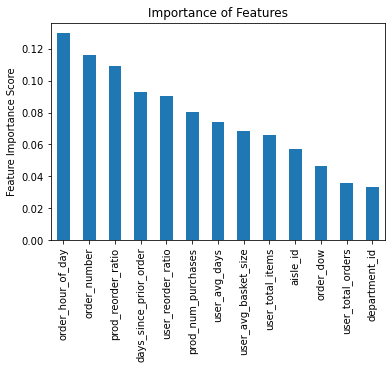

In [48]:
predictors = list(X_train)
feat_imp = pd.Series(rf.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar',title='Importance of Features')
plt.ylabel('Feature Importance Score')

## Model Comparison

In [51]:
labels = ['Logistic Regression','Gradient Boosting','Random Forest']
scores_test= [cv_scores_lr_test,cv_scores_gb_test,cv_scores_rf_test]
scores_train= [cv_scores_lr_train,cv_scores_gb_train,cv_scores_rf_train]
accuracy_scores = [accuracy_lr,accuracy_gb,accuracy_rf]

score_tab_acc = pd.DataFrame(list(zip(labels, accuracy_scores)), 
               columns =['Algorithm', 'Model Accuracy Score']) 

score_tab = pd.DataFrame(list(zip(labels, scores_train, scores_test)), 
               columns =['Algorithm', 'ROC-AUC Train Score', 'ROC-AUC Test Score' ])

score_tab_acc

,Algorithm,Model Accuracy Score
0,Logistic Regression,0.741736
1,Gradient Boosting,0.751214
2,Random Forest,0.759345


In [52]:
score_tab

,Algorithm,ROC-AUC Train Score,ROC-AUC Test Score
0,Logistic Regression,0.821613,0.820162
1,Gradient Boosting,0.834044,0.832633
2,Random Forest,0.837478,0.830043


In [53]:
precision_scores = [precision_lr,precision_gb,precision_rf]
precision_tab = pd.DataFrame(list(zip(labels, precision_scores)), 
               columns =['Algorithm', 'Model Precision Score']) 
precision_tab

,Algorithm,Model Precision Score
0,Logistic Regression,0.694425
1,Gradient Boosting,0.707842
2,Random Forest,0.725366


In [54]:
recall_scores = [recall_lr,recall_gb,recall_rf]
recall_tab = pd.DataFrame(list(zip(labels, recall_scores)), 
               columns =['Algorithm', 'Model Recall Score']) 
recall_tab

,Algorithm,Model Recall Score
0,Logistic Regression,0.863403
1,Gradient Boosting,0.855551
2,Random Forest,0.834728


([<matplotlib.axis.XTick at 0x7f933646d370>,
 [Text(0, 0, 'Logistic Regression'),
  Text(0, 0, 'Gradient Boosting'),
  Text(0, 0, 'Random Forest')])

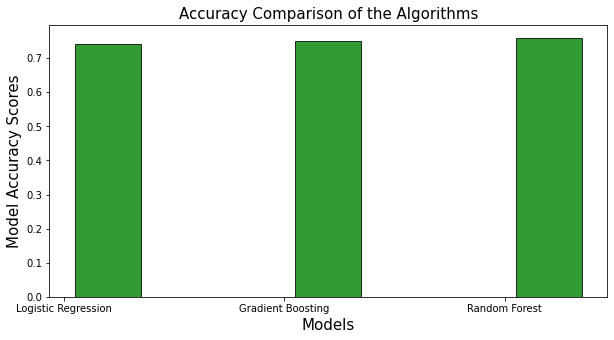

In [57]:
# Plotting the accuracy scores
index=[1,2,3]
index_acc=[1.2,2.2,3.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model Accuracy Scores',fontsize=15)
plt.title('Accuracy Comparison of the Algorithms',fontsize=15)
_=plt.bar(index_acc,accuracy_scores,color='green',alpha=0.8,label='Accuracy Scores',edgecolor='k',width=0.3)
plt.xticks([1,2,3], labels)

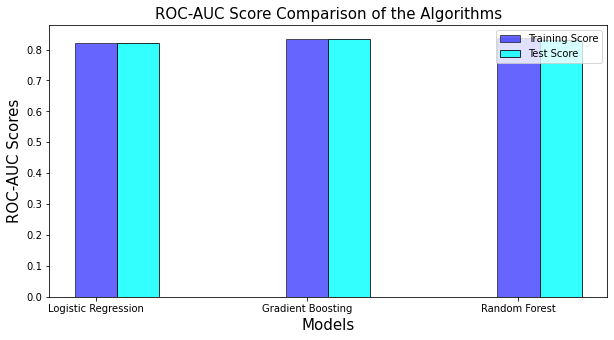

In [58]:
# Plotting and comparing ROC-AUC train/test scores
index=[1,2,3]
index_acc=[1.2,2.2,3.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC Scores',fontsize=15)
plt.title('ROC-AUC Score Comparison of the Algorithms',fontsize=15)
_=plt.bar(index,scores_train,color='b',alpha=0.6,label='Training Score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,scores_test,color='cyan',alpha=0.8,label='Test Score',edgecolor='k',width=0.2)
plt.xticks([1,2,3], labels)
plt.legend()

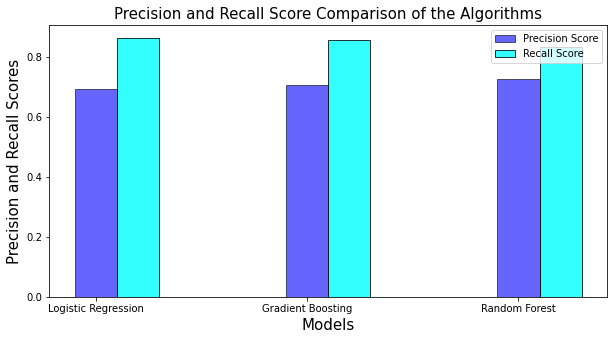

In [59]:
# Plotting and comparing precision and recall scores
index=[1,2,3]
index_acc=[1.2,2.2,3.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Precision and Recall Scores',fontsize=15)
plt.title('Precision and Recall Score Comparison of the Algorithms',fontsize=15)
_=plt.bar(index,precision_scores,color='b',alpha=0.6,label='Precision Score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,recall_scores,color='cyan',alpha=0.8,label='Recall Score',edgecolor='k',width=0.2)
plt.xticks([1,2,3], labels)
plt.legend()

The three models have comparable accuracy, ROC-AUC, precision, and recall scores. However, the Random Forest model is slightly better in terms of accuracy and precision. Additionally, the Random Forest model allows me to easily extract the feature importances. On the other hand, the Random Forest model took the longest amount of time to train and make predictions, but this is a tradeoff I'm willing to accept. Therefore, I conclude that the Random Forest model is the best model. 